## Introduction

Here is how to train a sequence classifier on one batch

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [2]:
checkpoint = "bert-base-uncased" ## Define Checkpoint
tokenizer = AutoTokenizer.from_pretrained(checkpoint) ## Load tokenizer
model = AutoModelForSequenceClassification.from_pretrained(checkpoint) ## Load model

## Same sequence
sequences = [
    "I've been waiting for a HuggingFace course my whole life.",
    "This course is amazing!",
]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [3]:
batch = tokenizer(sequences, padding=True, truncation=True, return_tensors="pt") ## creating batch returning Pytorch Tensors

In [6]:
batch['labels'] = torch.tensor([1,1]) ## Define Labels
optimizer = torch.optim.AdamW(model.parameters()) ## Feeding model parameters to optimizer
loss = model(**batch).loss ## compute loss
loss.backward() ## get gradients
optimizer.step()

Of course, just training the model on two sentences is not going to yield very good results. To get better results, you will need to prepare a bigger dataset.

## Loading Dataset from the Hub

The 🤗 Datasets library allows you to easily download and cache datasets.

In [8]:
from datasets import load_dataset

Downloading MRPC (Microsoft Research Paraphrase Corpus) dataset, introduced in a paper by William B. Dolan and Chris Brockett. The dataset consists of 5,801 pairs of sentences, with a label indicating if they are paraphrases or not (i.e., if both sentences mean the same thing). 

In [9]:
raw_datasets = load_dataset("glue", "mrpc")

Dataset glue downloaded and prepared to /home/aaagraw/.cache/huggingface/datasets/glue/mrpc/1.0.0/7c99657241149a24692c402a5c3f34d4c9f1df5ac2e4c3759fadea38f6cb29c4. Subsequent calls will reuse this data.


In [10]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

We can access any split of the dataset by its key, then any element by index. Only dataset asked gets loaded in memory.

In [11]:
raw_datasets['train'][6]

{'idx': 6,
 'label': 0,
 'sentence1': 'The Nasdaq had a weekly gain of 17.27 , or 1.2 percent , closing at 1,520.15 on Friday .',
 'sentence2': 'The tech-laced Nasdaq Composite .IXIC rallied 30.46 points , or 2.04 percent , to 1,520.15 .'}

We can also get a slice of data as well

In [12]:
raw_datasets['train'][:5]

{'idx': [0, 1, 2, 3, 4],
 'label': [1, 0, 1, 0, 1],
 'sentence1': ['Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .',
  "Yucaipa owned Dominick 's before selling the chain to Safeway in 1998 for $ 2.5 billion .",
  'They had published an advertisement on the Internet on June 10 , offering the cargo for sale , he added .',
  'Around 0335 GMT , Tab shares were up 19 cents , or 4.4 % , at A $ 4.56 , having earlier set a record high of A $ 4.57 .',
  'The stock rose $ 2.11 , or about 11 percent , to close Friday at $ 21.51 on the New York Stock Exchange .'],
 'sentence2': ['Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .',
  "Yucaipa bought Dominick 's in 1995 for $ 693 million and sold it to Safeway for $ 1.8 billion in 1998 .",
  "On June 10 , the ship 's owners had published an advertisement on the Internet , offering the explosives for sale .",
  'Tab shares jumped 20

Getting training dataset

In [13]:
raw_train_dataset = raw_datasets["train"]
raw_train_dataset[0]

{'idx': 0,
 'label': 1,
 'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .',
 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .'}

The feature attribute gives us more information about each column

In [14]:
raw_train_dataset.features

{'sentence1': Value(dtype='string', id=None),
 'sentence2': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=2, names=['not_equivalent', 'equivalent'], names_file=None, id=None),
 'idx': Value(dtype='int32', id=None)}

## Pre-processing a dataset

In [39]:
from transformers import AutoTokenizer
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

To tokenize multiple sentence we can pass two parameters in tokenizer

In [40]:
inputs = tokenizer("This is first sentence","This is second sentence")
inputs

{'input_ids': [101, 2023, 2003, 2034, 6251, 102, 2023, 2003, 2117, 6251, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [45]:
tokenizer.convert_ids_to_tokens(inputs['input_ids'])

['[CLS]',
 'this',
 'is',
 'first',
 'sentence',
 '[SEP]',
 'this',
 'is',
 'second',
 'sentence',
 '[SEP]']

For Sentence Pair: Inefficient Way

In [46]:
tokenized_dataset = tokenizer(
    raw_datasets['train']['sentence1'],
    raw_datasets['train']['sentence2'],
    padding=True,
    truncation=True
)

The above method loads everything in data (not good if you don't have enough RAM). 🤗 Datasets library are Apache Arrow files stored on the disk, so you only keep the samples you ask for loaded in memory).

To keep the data as a dataset, we will use the Dataset.map method. This also allows us some extra flexibility, if we need more preprocessing done than just tokenization. The map method works by applying a function on each element of the dataset, so let’s define a function that tokenizes our inputs:

In [49]:
def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

The way the 🤗 Datasets library applies this processing is by adding new fields to the datasets, one for each key in the dictionary returned by the preprocessing function:

In [50]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'idx', 'input_ids', 'label', 'sentence1', 'sentence2', 'token_type_ids'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['attention_mask', 'idx', 'input_ids', 'label', 'sentence1', 'sentence2', 'token_type_ids'],
        num_rows: 408
    })
    test: Dataset({
        features: ['attention_mask', 'idx', 'input_ids', 'label', 'sentence1', 'sentence2', 'token_type_ids'],
        num_rows: 1725
    })
})

The last thing we will need to do is pad all the examples to the length of the longest element when we batch elements together — a technique we refer to as dynamic padding.

## Dynamic Padding

Instead of applying padding at the entire text length, we can apply padding by looking at maximum length of a sentence within a specific batch, this technique is called batch padding. This will accelerate tokenization process in cpu and gpus but not in TPUs which expect fixed shapes.

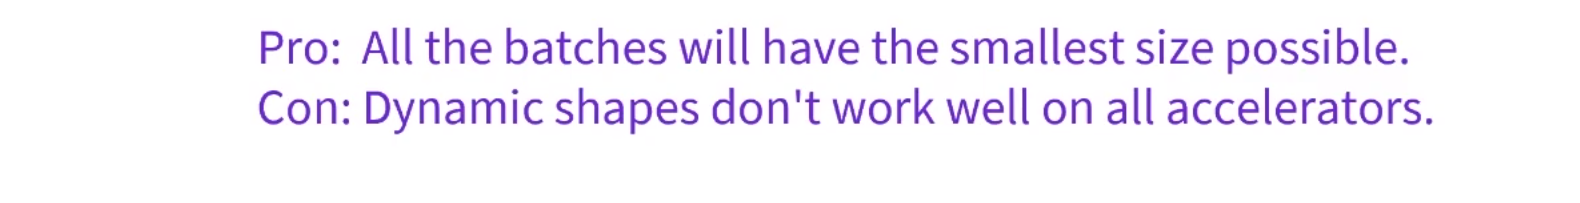
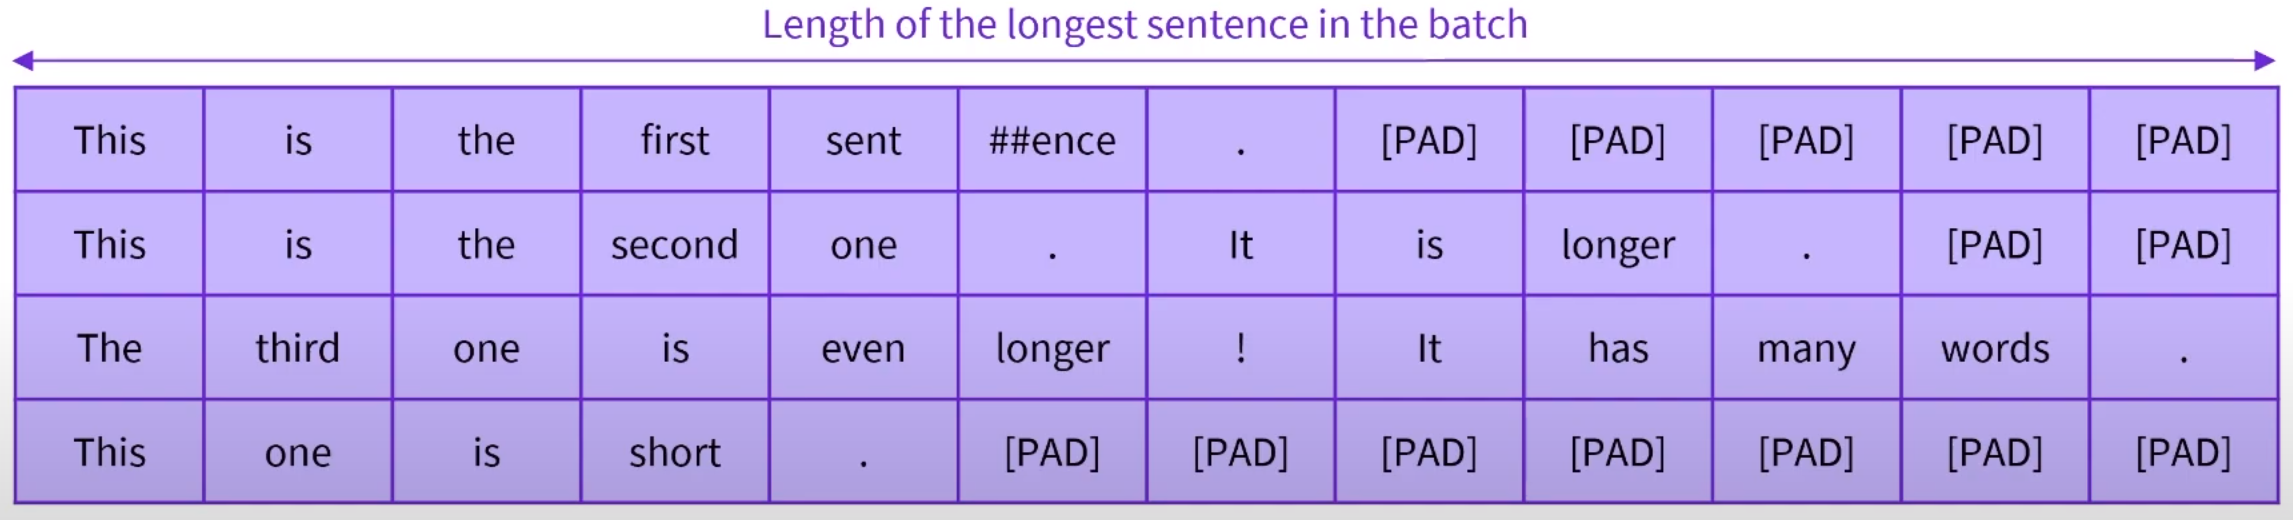

To do this in practice, we have to define a collate function that will apply the correct amount of padding to the items of the dataset we want to batch together. Fortunately, the 🤗 Transformers library provides us with such a function via DataCollatorWithPadding. It takes a tokenizer when you instantiate it (to know which padding token to use, and whether the model expects padding to be on the left or on the right of the inputs) and will do everything you need:

In [52]:
from transformers import DataCollatorWithPadding

In [53]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [59]:
samples = tokenized_datasets["train"][:8]
samples = {
    k: v for k, v in samples.items() if k not in ["idx", "sentence1", "sentence2"]
}
[len(x) for x in samples["input_ids"]]

[50, 59, 47, 67, 59, 50, 62, 32]

In [60]:
batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

{'attention_mask': torch.Size([8, 67]),
 'input_ids': torch.Size([8, 67]),
 'token_type_ids': torch.Size([8, 67]),
 'labels': torch.Size([8])}

Now that we’ve gone from raw text to batches our model can deal with, we’re ready to fine-tune it!